To start the project run all but the last cell where you can specify the parameters and hyper parameters of the GAT.

We start with installing torch-geometric, networkx, and matplotlib

In [ ]:
!pip install torch-geometric networkx matplotlib

This is the surface code generator of a specified distance and error rate.

In [ ]:
import math
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from sklearn.model_selection import train_test_split

class ToricSurfaceCodeGenerator:
  def __init__(self, distance, error_rate):
    self.distance = distance
    self.error_rate = error_rate
    self.grid_size = 2 * distance - 1
    self.num_nodes = self.grid_size ** 2
    self.num_ancilla = self.num_nodes // 2
    self.ears_per_side = distance // 2
    self.data_idx, self.ancilla_Z_idx, self.ancilla_X_idx = self.getQubitIndexList()
    self.node_types = ['Data' if i % 2 == 0 else 'Ancilla' for i in range(self.num_nodes)]
    self.ancilla_elephant_ears = self.create_elephant_ears() # create these after so they appear at the end
    self.edge_index = self.generate_edge_index()
    self.edge_index_exteneded_ears = self.add_EE_to_edge_index()
    self.errors = [] # Ground Truth
    self.input_data = np.zeros(self.num_nodes, dtype=int)
    self.ancilla_states = np.zeros(self.num_ancilla, dtype=bool)  # Initialize ancilla qubit states

  def add_EE_to_edge_index(self):
    additional_edges = []
    index_list = list(self.ancilla_elephant_ears)

    n_nodes = int(self.num_nodes-len(self.ancilla_elephant_ears))

    # handle elephant ears
    # Top-Row - should be all Z
    edges = [node for node in self.data_idx if node <= self.grid_size]

    paired_edges = []
    if len(edges) % 2 != 0:
      edges = edges[:-1]  # Drop the last element if the count is odd
    for i in range(0, len(edges), 2):
      paired_edges.append([edges[i], edges[i + 1]])

    # for every Z in length of side, add edges
    for paired_edge in paired_edges:
      additional_edges.append([index_list[0], paired_edge[0]])
      additional_edges.append([index_list[0], paired_edge[1]])
      index_list.pop(0)

    # Right-Col - should be all X
    edges = []
    for row in range(0, self.grid_size, 2):
      end_of_row_index = ((row+1)*self.grid_size) - 1
      edges.append(end_of_row_index)

    paired_edges = []
    if len(edges) % 2 != 0:
      edges = edges[:-1]  # Drop the last element if the count is odd
    for i in range(0, len(edges), 2):
      paired_edges.append([edges[i], edges[i + 1]])

    for i, paired_edge in enumerate(paired_edges):
      additional_edges.append([index_list[0], paired_edge[0]])
      additional_edges.append([index_list[0], paired_edge[1]])
      index_list.pop(0)

    # Bottom-Row - should be all Z
    data_index_reversed = self.data_idx
    data_index_reversed.reverse()

    edges = [node for node in data_index_reversed if node >= (n_nodes - self.grid_size)]

    paired_edges = []
    if len(edges) % 2 != 0:
      edges = edges[:-1]  # Drop the last element if the count is odd
    for i in range(0, len(edges), 2):
      paired_edges.append([edges[i], edges[i + 1]])

    for paired_edge in paired_edges:
      additional_edges.append([index_list[0], paired_edge[0]])
      additional_edges.append([index_list[0], paired_edge[1]])
      index_list.pop(0)

    # Left-Col - should be all X
    data_index_reversed = [x for x in range(self.grid_size)]
    data_index_reversed.reverse()

    edges = []
    reversed_range = range(self.grid_size - 2 if self.grid_size % 2 == 0 else self.grid_size - 1, -1, -2)

    for row in reversed_range:
      end_of_row_index = (row)*self.grid_size
      edges.append(end_of_row_index)

    paired_edges = []
    if len(edges) % 2 != 0:
      edges = edges[:-1]  # Drop the last element if the count is odd
    for i in range(0, len(edges), 2):
      paired_edges.append([edges[i], edges[i + 1]])

    for paired_edge in paired_edges:
      additional_edges.append([index_list[0], paired_edge[0]])
      additional_edges.append([index_list[0], paired_edge[1]])
      index_list.pop(0)

    # Add additional pairs of edges
    # print("additional_edges:", additional_edges)
    # additional_edges = [[24, 0], [24, 2]]  for the 24th qubit
    for edge in additional_edges:
      self.edge_index = torch.cat((self.edge_index, torch.tensor(edge).unsqueeze(1)), dim=1)
    return 0

  def create_elephant_ears(self):
    EE_ancilla_types = []
    EE_ancilla_index = []
    # ancilla 1 is X so we start with Z going from Top-Left clockwise
    # [[ears_per_side], [ears_per_side], [ears_per_side], [ears_per_side]]
    # [Z, Z, Z ... X, X, X ..., Z, Z, Z ..., X, X, X]
    num_of_ZX_sides = 2
    for i in range(num_of_ZX_sides):
      EE_ancilla_types.extend(['Z'] * self.ears_per_side)
      EE_ancilla_types.extend(['X'] * self.ears_per_side)
    extra_ancilla = len(EE_ancilla_types)

    for i, node in enumerate(EE_ancilla_types):
      if node == 'Z':
        self.ancilla_Z_idx.append(self.num_nodes + i)
        EE_ancilla_index.append(self.num_nodes + i)
      if node == 'X':
        self.ancilla_X_idx.append(self.num_nodes + i)
        EE_ancilla_index.append(self.num_nodes + i)

    self.num_nodes += extra_ancilla
    for node in EE_ancilla_index:
      self.node_types.append('Ancilla')
    return EE_ancilla_index

  def getQubitIndexList(self):
    lattice = np.zeros([self.grid_size, self.grid_size], int)
    count=0
    data_qubit_index = []
    all_ancilla_index = []
    za_qubit_index = []
    xa_qubit_index = []

    for i in range(len(lattice[0])):
      for j in range(len(lattice[0])):
        lattice[i][j] = count
        count +=1

    for i, r in enumerate(lattice):
      for j, d in enumerate(lattice):
        # if it's an even row then it starts with a data qubit
        if i % 2 == 0:
          # if it's an even number it's data qubit
          if j % 2 == 0:
            data_qubit_index.append(lattice[i][j])
          else: # it's an odd number it's alternating ancilla
            all_ancilla_index.append(lattice[i][j])
        else: # if it's odd it starts with ancilla
          if j % 2 == 0:
            all_ancilla_index.append(lattice[i][j])
          else:
            data_qubit_index.append(lattice[i][j])

    smallest_ancilla_row = self.grid_size // 2
    largest_ancilla_row = math.ceil(self.grid_size / 2)

    i = 0
    while i < len(all_ancilla_index):
      xa_qubit_index.extend(all_ancilla_index[i:i+smallest_ancilla_row])
      za_qubit_index.extend(all_ancilla_index[i+smallest_ancilla_row:i+self.grid_size])
      i += self.grid_size

    return data_qubit_index, za_qubit_index, xa_qubit_index

  def generate_edge_index(self):
    edges = []
    for i in range(self.grid_size):
      for j in range(self.grid_size):
        idx = i * self.grid_size + j
        if j < self.grid_size - 1:  # Horizontal edges
          edges.append([idx, idx + 1])
        if i < self.grid_size - 1:  # Vertical edges
          edges.append([idx, idx + self.grid_size])
    edges = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return edges

  def apply_errors(self):
    for i in range(self.num_nodes):
      if np.random.random() < self.error_rate:
        error_type = np.random.choice(['X', 'Z', 'Y'])  # Randomly choose error type
        self.errors.append(error_type)
      else:
        self.errors.append('0')

  def getEdgesForNode(self, node):
    edges = []
    edges.append(self.edge_index[:, self.edge_index[0] == node])
    edges.append(self.edge_index[:, self.edge_index[1] == node])
    flattened_edges = [torch.flatten(edge) for edge in edges]
    flattened_edges = torch.cat(flattened_edges)
    filtered_edges = flattened_edges[flattened_edges != node]
    return filtered_edges

  def update_ancilla_states(self):
    # errrors get applied to data qubits first that effect ancilla, then ancilla applies errors ontop of those errors
    # Iterate over ground truth for errors
    # tensor([[ 0,  0,  1,  1,  2,  2,  3,... ],
     #        [ 1,  5,  2,  6,  3,  7,  4,... ]])
    for node in self.data_idx:
      if self.errors[node] != '0': #error
      # get edges of data node to update ancilla
        error_id = self.errors[node]
        edges_for_node = self.getEdgesForNode(node)
        if error_id == 'X':
          for edge in edges_for_node:
            if edge in self.ancilla_X_idx:
              self.input_data[edge] += 1
        elif error_id == 'Z':
          for edge in edges_for_node:
            if edge in self.ancilla_Z_idx:
              self.input_data[edge] += 1
        elif error_id == 'Y':
          for edge in edges_for_node:
            self.input_data[edge] += 1
    for i, node in enumerate(self.input_data):
      if node % 2 == 0:
        self.input_data[i] = 0
      elif node % 2 == 1:
        self.input_data[i] = 1

    # data qubit errors done now ancilla
    for node in self.ancilla_X_idx:
      node_state = self.input_data[node]  # Current state of the ancilla qubit: 0 or 1
      error_id = self.errors[node]  # Error that occurred when measured: 'X' or 'Y' or 'Z'
      if error_id == 'X' or error_id == 'Y':  # Both X and Y errors change the state from 0 to 1 or from 1 to 0
        self.input_data[node] = 1 - node_state  # Flip the state from 0 to 1 or from 1 to 0

    # Handling ancilla Z indexes
    for node in self.ancilla_Z_idx:
      node_state = self.input_data[node]  # Current state of the ancilla qubit: 0 or 1
      error_id = self.errors[node]  # Error that occurred when measured: 'X' or 'Y' or 'Z'
      if error_id == 'Y':  # Only Y errors change the state from 0 to 1 or from 1 to 0 for ancilla Z indexes
        self.input_data[node] = 1 - node_state  # Flip the state from 0 to 1 or from 1 to 0
    for i, node in enumerate(self.input_data):
      if node % 2 == 0:
        self.input_data[i] = 0
      elif node % 2 == 1:
        self.input_data[i] = 1

  def get_node_features(self):
    error_labels = {'X': 1, 'Z': 2, 'Y': 3, '0': 0}
    converted_errors = [error_labels[error] for error in self.errors]
    # node embedding will be [node type (Data or Ancilla), Measurement (on Ancilla), Ground Truth]
    x = torch.tensor([[self.node_types[i] == 'Data', self.input_data[i], converted_errors[i]]
                         for i in range(self.num_nodes)], dtype=torch.float)
    return x

Generate the graph data and edge index to be used in a custom dataset

In [ ]:
def generate_graph_data(distance, error_rate):
    generator = ToricSurfaceCodeGenerator(distance, error_rate)
    generator.apply_errors()
    generator.update_ancilla_states()  # Update ancilla states based on data errors
    x = generator.get_node_features()
    edge_index = generator.edge_index

    return x, edge_index

for plotting our accuracy and loss after each combination of parameters

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(metrics):
    epochs = range(1, len(metrics['loss']) + 1)

    # Plotting Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['loss'], 'b', label='Training loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['accuracy'], 'r', label='Training accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
  def __init__(self, num_features, hidden_channels, num_classes, num_layers, heads):
    super(GAT, self).__init__()
    self.conv1 = GATConv(num_features, hidden_channels, heads=heads)
    self.convs = torch.nn.ModuleList()
    for _ in range(num_layers - 2):
      self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads))
    self.conv2 = GATConv(hidden_channels * heads, num_classes, heads=1)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.elu(x)
    for conv in self.convs:
      x = conv(x, edge_index)
      x = F.elu(x)
    x = self.conv2(x, edge_index)
    return F.log_softmax(x, dim=1)


def train(model, optimizer, criterion, train_graphs):
  model.train()
  total_loss = 0
  total_correct = 0
  total_examples = 0
  for graph_data in train_graphs:
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index)
    loss = criterion(out, graph_data.y)
    loss.backward()
    optimizer.step()

    # Compute accuracy
    predicted = out.argmax(dim=1)
    correct = predicted.eq(graph_data.y)
    total_correct += correct.sum().item()
    total_examples += graph_data.num_nodes

    total_loss += loss.item()
  # Compute average loss and accuracy
  avg_loss = total_loss / len(train_graphs)
  accuracy = total_correct / total_examples
  return avg_loss, accuracy

def test(model, test_graphs):
  model.eval()
  total_correct = 0
  total_test_samples = 0
  for graph_data in test_graphs:
    out = model(graph_data.x, graph_data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct = pred == graph_data.y  # Check against ground-truth labels.
    total_correct += correct.sum().item()
    total_test_samples += len(graph_data.y)  # Count all labeled nodes in the graph
  test_acc = total_correct / total_test_samples  # Derive ratio of correct predictions.
  return test_acc

In order to se the graphs how we want to we need to create our own torch dataset here

In [ ]:
# Create our own dataset from the graphs
class CustomDataset(Dataset):
  def __init__(self, num_graphs, distance, error_rate):
    super(CustomDataset, self).__init__()
    self.graph_data_list = []

    for _ in range(num_graphs):
      x, edge_index = generate_graph_data(distance, error_rate)
      graph_data = Data(x=x, edge_index=edge_index, y = x[:, 2].long())

      self.graph_data_list.append(graph_data)

  def __len__(self):
    return len(self.graph_data_list)

  def __getitem__(self, idx):
    return self.graph_data_list[idx]

In [ ]:
import random
def generate_multiple_graphs(num_graphs, distances, error_rates, hyperparameters):
    # generate num_graphs for each distance and multiple error rates
    graph_data_list = []
    for distance in distances:
      print("Starting with distance: ", distance)
      for error_rate in error_rates:
        print("Starting with error rate: ", error_rate)
        graph_data = []
        dataset = CustomDataset(num_graphs, distance, error_rate)

        # start the GNN for graph_data
        # split for training and testing
        dataset_list = list(dataset)
        random.shuffle(dataset_list)  # Shuffle the dataset
        train_size = int(0.8 * len(dataset_list))
        train_graphs = dataset_list[:train_size]
        test_graphs = dataset_list[train_size:]



        best_accuracy = 0
        best_hyperparameters = None

        for hidden_size in hyperparameters['hidden_size']:
          for num_layers in hyperparameters['num_layers']:
            for lr in hyperparameters['lr']:
              for weight_decay in hyperparameters['weight_decay']:
                num_features = dataset[0].num_features
                num_classes = dataset.num_classes
                model = GAT(num_features=num_features, hidden_channels=hidden_size, num_classes=num_classes, num_layers=num_layers, heads=hyperparameters['heads'])
                print(model)
                optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
                criterion = torch.nn.CrossEntropyLoss()

                losses = []
                accuracies = []
                for epoch in range(1, hyperparameters['epochs']+1):
                  avg_loss, accuracy = train(model, optimizer, criterion, train_graphs)
                  losses.append(avg_loss)
                  accuracies.append(accuracy)
                plot_metrics({'loss': losses, 'accuracy': accuracies})
                print(f'Distance: {distance}, Error Rate: {error_rate}, Hidden Size: {hidden_size}, Num Layers: {num_layers}, LR: {lr}, Weight Decay: {weight_decay}, Epoch: {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
                accuracy = test(model, test_graphs)
                if accuracy > best_accuracy:
                  best_accuracy = accuracy
                  best_hyperparameters = {
                    'distance': distance,
                    'error_rate': error_rate,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'lr': lr,
                    'weight_decay': weight_decay
                  }


        print(f'Distance: {distance}, Error Rate: {error_rate}, Hidden Size: {hidden_size}, Num Layers: {num_layers}, LR: {lr}, Weight Decay: {weight_decay}, Epoch: {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
        print("Best Accuracy: ", best_accuracy, "Best Hyperparameters", best_hyperparameters)
    return best_accuracy, best_hyperparameters



Set parameters here, if they are in an arry you can add more than one paramter to test.

Starting with distance:  3
Starting with error rate:  0.4
GAT(
  (conv1): GATConv(3, 32, heads=4)
  (convs): ModuleList()
  (conv2): GATConv(128, 4, heads=1)
)


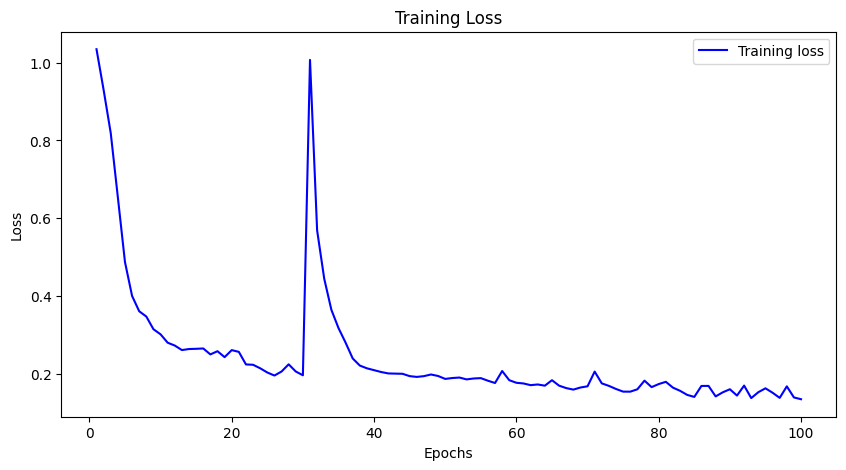

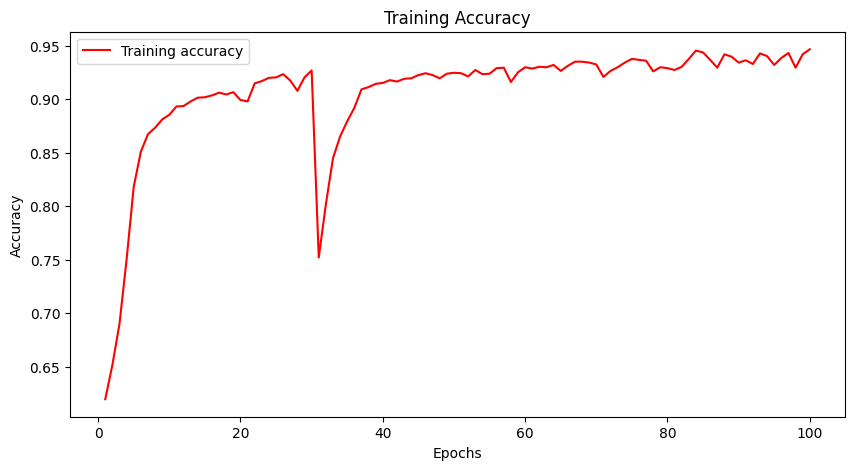

Distance: 3, Error Rate: 0.4, Hidden Size: 32, Num Layers: 2, LR: 0.01, Weight Decay: 0.0008, Epoch: 100, Avg Loss: 0.1354, Accuracy: 0.9466
Distance: 3, Error Rate: 0.4, Hidden Size: 32, Num Layers: 2, LR: 0.01, Weight Decay: 0.0008, Epoch: 100, Avg Loss: 0.1354, Accuracy: 0.9293
Best Accuracy:  0.9293103448275862 Best Hyperparameters {'distance': 3, 'error_rate': 0.4, 'hidden_size': 32, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0008}
best_accuracy, best_hyperparameters
0.9293103448275862 {'distance': 3, 'error_rate': 0.4, 'hidden_size': 32, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0008}


In [ ]:
# Parameters
num_graphs = 100
distances = [3]
error_rates = [0.4]

# Define hyperparameter configurations
hyperparameters = {
    'hidden_size': [32],
    'num_layers': [2],
    'lr': [0.01],
    'weight_decay': [8e-4],
    'epochs': 100,
    # 'batch size': 4096,
    'heads': 4,
    # 'hidden dropout': 0.1,
}

best_accuracy, best_hyperparameters = generate_multiple_graphs(num_graphs, distances, error_rates, hyperparameters)
print("best_accuracy, best_hyperparameters")
print(best_accuracy, best_hyperparameters)